In [166]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal, interpolate, integrate, stats
from scipy import constants as spc
import h5py

In [167]:
smart = np.genfromtxt("../src/smarts295.ext.txt", skip_header=1)
smart[:,[1,2,5]] *= 1000
# Wl, direct normal, diffuse horiz, direct transmittance, dir PAR PPDF, solar

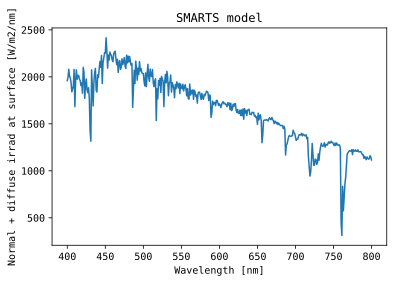

In [168]:
plt.plot(smart[:,0], smart[:,1] + smart[:,2]);
plt.xlabel("Wavelength [nm]");
plt.ylabel("Normal + diffuse irrad at surface [W/m2/nm]");
plt.title("SMARTS model");

In [169]:
coart_raw = open("../src/coart_irrad.txt").read().splitlines()
coart_wl = np.array([float(x[-4:]) for x in coart_raw[8::9]]) * 1e3
coart_down_irrad = np.array([float(x[-20:-11]) for x in coart_raw[13::9]]) # W/m2/um
coard_down_rad = np.array([float(x[-10:]) for x in coart_raw[15::9]]) # W/m2/um/sr

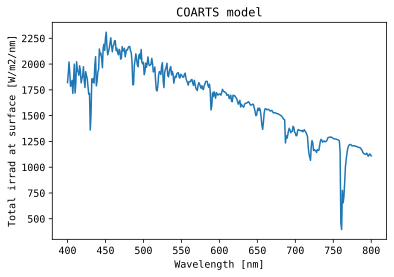

In [170]:
plt.plot(coart_wl, coart_down_irrad);
plt.xlabel("Wavelength [nm]");
plt.ylabel("Total irrad at surface [W/m2/nm]");
plt.title("COARTS model");

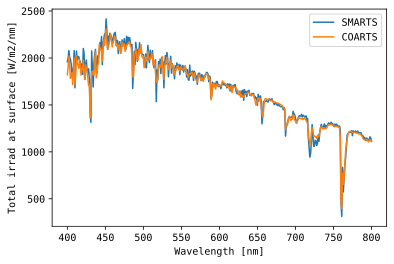

In [171]:
plt.plot(smart[:,0], smart[:,1] + smart[:,2], label="SMARTS");
plt.plot(coart_wl, coart_down_irrad, label="COARTS");
plt.xlabel("Wavelength [nm]");
plt.ylabel("Total irrad at surface [W/m2/nm]");
plt.legend();

In [172]:
smart_solar = smart[:,5] / (spc.h * spc.c / (smart[:,0] * 1e-9))

In [173]:
TSIS = h5py.File("/home/psomkuti/TSIS-SIM-scaled_l2_solar_model.h5", "r")

In [174]:
TSIS_cont_wl = 1e7 / TSIS['Solar/Continuum/Continuum_1/wavenumber'][:][::-1]
TSIS_cont_spec = TSIS['Solar/Continuum/Continuum_1/spectrum'][:][::-1]

TSIS_abs_wl = 1e7 / TSIS['Solar/Absorption/Absorption_1/wavenumber'][:][::-1]
TSIS_abs_spec = TSIS['Solar/Absorption/Absorption_1/spectrum'][:][::-1]

delta_wl = 1e-4
TSIS_wl = np.arange(752, 787, delta_wl)
TSIS_cont = interpolate.interp1d(TSIS_cont_wl, TSIS_cont_spec)(TSIS_wl)
TSIS_abs = interpolate.interp1d(TSIS_abs_wl, TSIS_abs_spec)(TSIS_wl)

In [175]:
def gauss(x, sigma): return (1.0 / sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / sigma)**2)

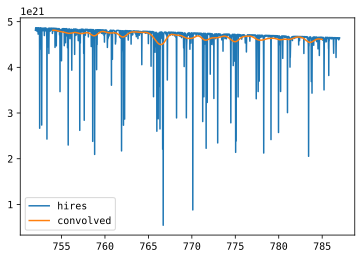

In [176]:
sigma = 0.4
kernel = gauss(np.arange(-2, 2, delta_wl), sigma)
kn = int(len(kernel)/2)
convolved = signal.convolve(TSIS_abs * TSIS_cont, kernel, mode='valid') / sum(kernel)
plt.plot(TSIS_wl, TSIS_abs * TSIS_cont, label="hires");
plt.plot(TSIS_wl[kn:-kn+1], convolved, label="convolved");
plt.legend();

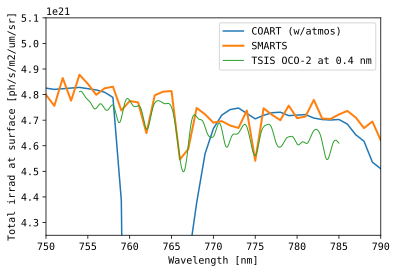

In [177]:
plt.plot(coart_wl, coart_down_irrad / (spc.h * spc.c / (coart_wl * 1e-9)), label="COART (w/atmos)");
plt.plot(smart[:,0], smart_solar, label="SMARTS", lw=2.0);
plt.plot(TSIS_wl[kn:-kn+1], convolved, label=f"TSIS OCO-2 at {sigma} nm", lw=1.0);
plt.xlim(750, 790);
plt.ylim(4.25e21, 5.1e21);
plt.legend()
plt.xlabel("Wavelength [nm]");
plt.ylabel("Total irrad at surface [ph/s/m2/um/sr]");

In [178]:
# Check PPDF calculation [umol/s/m2]
int_idx = (smart[:,0] >= 400) & (smart[:,0] <= 700)

ppdf1 = (1e-3 / (spc.c * spc.h * spc.N_A)) * integrate.trapz(
    smart[int_idx,0] * (smart[int_idx,1] + smart[int_idx,2]) / 1000, 
    smart[int_idx,0])


int_idx = (coart_wl >= 400) & (coart_wl <= 700)

ppdf2 = (1e-3 / (spc.c * spc.h * spc.N_A)) * integrate.trapz(
    coart_wl[int_idx] * coart_down_irrad[int_idx] / 1000, 
    coart_wl[int_idx]) 

In [179]:
for ppdf in [ppdf1, ppdf2]:
    print(f"PPDF value : {ppdf:0.5f}")

PPDF value : 2470.50140
PPDF value : 2448.67875
